# Pump it Up: Data Mining the Water Table

### Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, we are trying to predict which pumps are functional, which need some repairs, and which don't work at all based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. 

A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline


print("Setup Complete")

Setup Complete


In [157]:
# Load the data after EDA
train_df = pd.read_csv("train_df")
X_test = pd.read_csv("X_test")

# 2. Data Cleaning & Preprocessing

## 2.1 Dropping the features containing similar information

The following groups of features

- (extraction_type, extraction_type_group, extraction_type_class),
- (payment, payment_type),
- (water_quality, quality_group),
- (source, source_class),
- (subvillage, region, region_code, district_code, lga, ward),
- (waterpoint_type, waterpoint_type_group)
- (scheme_name, scheme_management)

contain very similar information, so the correlation between them is high. This way we are risking overfitting the training data by including all the features in our analysis.

Besides:

num_private is ~99% zeros and has no description, so we cannot interpret it
in the wpt_name feature 45k unique values out of 75k observations, not very informative -> drop for now

**TO DO**: The correlation between "construction_year" and "gps_height" is high, but these 2 variables don't have any obvious connection, so explore this correlation further to take a decision.

As we saw earlier, there exists quite a strong correlation between district_code and region_code, so we will drop one of these variables. The negative correlation to the target variable of the "region_code" is higher than that of the "district_code". Keep the variable with higher correlation to the target.

In [158]:
# drop columns
train_df = train_df.drop(['installer','management_group','status_group','id_x','id_y', 'num_private', 'wpt_name', 
          'recorded_by', 'subvillage', 'scheme_name', 'region', 
          'quantity', 'water_quality', 'lga','ward', 'source_type', 'payment', 
          'waterpoint_type_group','extraction_type_group','extraction_type_class'],axis=1)
X_test = X_test.drop(['installer','management_group','id', 'num_private', 'wpt_name', 
          'recorded_by', 'subvillage', 'scheme_name', 'region', 
          'quantity', 'water_quality', 'lga','ward', 'source_type', 'payment', 
          'waterpoint_type_group','extraction_type_group','extraction_type_class'],axis=1)

In [159]:
train_df.head()

,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,basin,region_code,district_code,population,...,construction_year,extraction_type,management,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,label
0,6000.0,2011-03-14,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,109,...,1999,gravity,vwc,annually,good,enough,spring,groundwater,communal standpipe,2
1,0.0,2013-03-06,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,280,...,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,2
2,25.0,2013-02-25,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,250,...,2009,gravity,vwc,per bucket,good,enough,dam,surface,communal standpipe multiple,2
3,0.0,2013-01-28,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,58,...,1986,submersible,vwc,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,0
4,0.0,2011-07-13,Action In A,0,31.130847,-1.825359,Lake Victoria,18,1,0,...,0,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,2


## 2.2 Dealing with missing values

In [160]:
# Categorical columns

## Replacing null subvillage values with the most frequent values of subvillage for that region_code
lat_map_na = train_df.groupby('region_code')['latitude'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
long_map_na = train_df.groupby('region_code')['longitude'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
pop_map_na = train_df.groupby('region_code')['population'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
gps_map_na = train_df.groupby('region_code')['gps_height'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()

lat_mask = (train_df.latitude.isnull()) & (train_df.loc[train_df["latitude"] == 0, "latitude"])
long_mask = (train_df.longitude.isnull()) & (train_df.loc[train_df["longitude"] == 0, "longitude"])
pop_mask = (train_df.population.isnull()) & (train_df.loc[train_df['population'] == 0, 'population'])
gps_mask = (train_df.gps_height.isnull()) & (train_df.loc[train_df['gps_height'] == 0, 'gps_height'])

train_df.loc[lat_mask, 'latitude'] = train_df.loc[lat_mask, 'region_code'].map(lat_map_na)
train_df.loc[long_mask, 'longitude'] = train_df.loc[long_mask, 'region_code'].map(long_map_na)
train_df.loc[pop_mask, 'population'] = train_df.loc[pop_mask, 'region_code'].map(pop_map_na)
train_df.loc[gps_mask, 'gps_height'] = train_df.loc[gps_mask, 'region_code'].map(gps_map_na)

X_test.loc[lat_mask, 'latitude'] = X_test.loc[lat_mask, 'region_code'].map(lat_map_na)
X_test.loc[long_mask, 'longitude'] = X_test.loc[long_mask, 'region_code'].map(long_map_na)
X_test.loc[pop_mask, 'population'] = X_test.loc[pop_mask, 'region_code'].map(pop_map_na)
X_test.loc[gps_mask, 'gps_height'] = X_test.loc[gps_mask, 'region_code'].map(gps_map_na)

In [161]:
## Null scheme_management, funder, installer, public_meeting and permit values replace with "unknown" text
train_df["scheme_management"].fillna("unknown", inplace = True)
train_df["public_meeting"].fillna("unknown", inplace = True)
train_df["permit"].fillna("unknown", inplace = True)
train_df["funder"].fillna("unknown", inplace = True)
# train_df["installer"].fillna("unknown", inplace = True)

X_test["scheme_management"].fillna("unknown", inplace = True)
X_test["public_meeting"].fillna("unknown", inplace = True)
X_test["permit"].fillna("unknown", inplace = True)
X_test["funder"].fillna("unknown", inplace = True)
# X_test["installer"].fillna("unknown", inplace = True)

In [162]:
train_df.isna().sum().sort_values(ascending=False)

label                0
public_meeting       0
date_recorded        0
funder               0
gps_height           0
longitude            0
latitude             0
basin                0
region_code          0
district_code        0
population           0
scheme_management    0
waterpoint_type      0
permit               0
construction_year    0
extraction_type      0
management           0
payment_type         0
quality_group        0
quantity_group       0
source               0
source_class         0
amount_tsh           0
dtype: int64

In [163]:
X_test.isna().sum().sort_values(ascending=False)

waterpoint_type      0
source_class         0
date_recorded        0
funder               0
gps_height           0
longitude            0
latitude             0
basin                0
region_code          0
district_code        0
population           0
public_meeting       0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
payment_type         0
quality_group        0
quantity_group       0
source               0
amount_tsh           0
dtype: int64

## ** 2.3 Transforming data to reduce skew
Uni-modal, skewed distributions could potentially be log transformed: 
* Longtitude
* GPS_hight
* Region_code

** For later

## 2.3 Linear Discriminant Analysis (LDA)

LDA helps reducing dimentiality by maximizing the difference between categories. In our highly dimentional model it is a great tool. We will use LDA for the following columns as all of them contain geographical information:
 
- latitude
- longitude
- gps_height

Reference: https://zlatankr.github.io/posts/2017/01/23/pump-it-up

In [164]:
LDA_cols = ["latitude","longitude","gps_height"]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

train_df_sc = sc.fit_transform(train_df[LDA_cols])
X_test_sc = sc.transform(X_test[LDA_cols])

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=None)

train_df_lda = lda.fit_transform(train_df_sc, train_df.label.values.ravel())
X_test_lda = lda.transform(X_test_sc)

train_df = pd.concat((pd.DataFrame(train_df_lda), train_df), axis=1)
X_test = pd.concat((pd.DataFrame(X_test_lda), X_test), axis=1)
    
    
for i in LDA_cols:
    del train_df[i]
    del X_test[i]

## 2.4 Reducing cardinality

In [165]:
# Get number of unique entries in each column with categorical data
cat_vars = train_df.select_dtypes(include='object').columns
object_nunique = list(map(lambda col: train_df[col].nunique(), cat_vars))
d = dict(zip(cat_vars, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('public_meeting', 3),
 ('permit', 3),
 ('source_class', 3),
 ('quantity_group', 5),
 ('quality_group', 6),
 ('payment_type', 7),
 ('waterpoint_type', 7),
 ('basin', 9),
 ('source', 10),
 ('management', 12),
 ('scheme_management', 13),
 ('extraction_type', 18),
 ('date_recorded', 356),
 ('funder', 1898)]

Based on the above analysis:

the "recorded_by" feature can be dropped as there is only 1 unique value, it doesn't help in predicting.

The columns in which values can be ordered we can perform an Ordinal encoding: 
* quality_group
* quantity_group
* payment_type

The cardinality of the following 2 features should be reduced to 10 and then one-hot encode them or try Binary encoding:
* scheme_managenemt
* extraction_type

What to do with the following 3? The cardinality is too high... : --> will drop at the first model run, later could try Frequency encoding,Binary encoding if reduce cardinality to at least 100.
* funder
* installer
* subvillage

The rest can be one-hot encoded as the cardinality is lower than 10:
* public_meeting # later -> Binary?
* permit # later-> Binary?
* source_class
* management_group
* waterpoint_type_group
* source_type
* basin

In [166]:
# Reduce cardinality for the following 4 features:
## scheme_management
## extraction_type
## funder
## installer
train_df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
unknown              3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [167]:
## scheme_management
def scheme_wrangler(row):
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    elif row['scheme_management']=='Parastatal':
        return 'Parastatal'
    elif row['scheme_management']=='Private operator':
        return 'pri_optr'
    elif row['scheme_management']=='SWC':
        return 'swc'
    elif row['scheme_management']=='Company':
        return 'company'
    else:
        return 'other'
train_df['scheme_management'] = train_df.apply(lambda row: scheme_wrangler(row), axis=1)
X_test['scheme_management'] = X_test.apply(lambda row: scheme_wrangler(row), axis=1)

In [168]:
## extraction_type
train_df.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [169]:
## extraction_type
def extraction_wrangler(row):
    if row['extraction_type']=='gravity':
        return 'gravity'
    elif row['extraction_type']=='nira/tanira':
        return 'nira/tanira'
    elif row['extraction_type']=='submersible':
        return 'submersible'
    elif row['extraction_type']=='swn 80':
        return 'swn_80'
    elif row['extraction_type']=='mono':
        return 'mono'
    elif row['extraction_type']=='india mark ii':
        return 'india_mark_ii'
    elif row['extraction_type']=='afridev':
        return 'afridev'
    elif row['extraction_type']=='ksb':
        return 'ksb'
    elif row['extraction_type']=='windmill':
        return 'windmill'
    else:
        return 'other'
train_df['extraction_type'] = train_df.apply(lambda row: extraction_wrangler(row), axis=1)
X_test['extraction_type'] = X_test.apply(lambda row: extraction_wrangler(row), axis=1)

In [170]:
## funder
train_df.funder.value_counts()

Government Of Tanzania           9084
unknown                          3635
Danida                           3114
Hesawa                           2202
Rwssp                            1374
World Bank                       1349
Kkkt                             1287
World Vision                     1246
Unicef                           1057
Tasaf                             877
District Council                  843
Dhv                               829
Private Individual                826
Dwsp                              811
0                                 777
Norad                             765
Germany Republi                   610
Tcrs                              602
Ministry Of Water                 590
Water                             583
Dwe                               484
Netherlands                       470
Hifab                             450
Adb                               448
Lga                               442
Amref                             425
Fini Water  

In [171]:
## funder
def funder_wrangler(row):  
    '''Keep top 8 values and set the rest to 'other'''

    if row['funder']=='Government Of Tanzania':
        return 'gov'
    elif row['funder']=='Danida':
        return 'danida'
    elif row['funder']=='Hesawa':
        return 'hesawa'
    elif row['funder']=='Rwssp':
        return 'rwssp'
    elif row['funder']=='World Bank':
        return 'world_bank'   
    elif row['funder']=='Kkkt':
        return 'kkkt'   
    elif row['funder']=='World Vision':
        return 'world_vision'  
    elif row['funder']=='Unicef':
        return 'unicef'
    else:
        return 'other'
    
train_df['funder'] = train_df.apply(lambda row: funder_wrangler(row), axis=1)
X_test['funder'] = X_test.apply(lambda row: funder_wrangler(row), axis=1)

In [172]:
## installer
# train_df.installer.value_counts()

In [173]:
## installer
# def installer_wrangler(row):
#     '''Keep top 5 values and set the rest to 'other'''
#     if row['installer']=='DWE':
#         return 'dwe'
#     elif row['installer']=='Government':
#         return 'gov'
#     elif row['installer']=='RWE':
#         return 'rwe'
#     elif row['installer']=='Commu':
#         return 'commu'
#     elif row['installer']=='DANIDA':
#         return 'danida'
#     else:
#         return 'other'  

# train_df['installer'] = train_df.apply(lambda row: installer_wrangler(row), axis=1)
# X_test['installer'] = X_test.apply(lambda row: installer_wrangler(row), axis=1)

## 2.5 Ordinal encoding of categorical data

In [174]:
# Ordinal encoding: Encode quality_group, quantity_group and payment_type simply with the dictionaries
train_df.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [175]:
order_dict_quality = {"good":3,"salty":2,"milky":2,"colored":2,"fluoride":2,"unknown":1}
train_df["quality_group_code"] = [order_dict_quality[item] for item in train_df.quality_group]
del train_df["quality_group"]

X_test["quality_group_code"] = [order_dict_quality[item] for item in X_test.quality_group]
del X_test["quality_group"]

In [176]:
train_df.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [177]:
order_dict_quantity = {"enough":3,"insufficient":2,"dry":2,"seasonal":2,"unknown":1}
train_df["quantity_group_code"] = [order_dict_quantity[item] for item in train_df.quantity_group] 
del train_df["quantity_group"]

X_test["quantity_group_code"] = [order_dict_quantity[item] for item in X_test.quantity_group] 
del X_test["quantity_group"]

In [178]:
train_df.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [179]:
order_dict_payment = {"monthly":4,"annually":4,"on failure":3,"per bucket":3,"never pay":2,"unknown":1,"other":1}
train_df["payment_code"] = [order_dict_payment[item] for item in train_df.payment_type] 
del train_df["payment_type"]

X_test["payment_code"] = [order_dict_payment[item] for item in X_test.payment_type] 
del X_test["payment_type"]

## 2.6 Feature Engineering
1. Amount_tsh binary var
2. Construction year -> bins
3. Date recorded -> convert to datetime -> number of days since the most recent
4. Interactions

** Long + Lat variable -> tried using zip but models can't process a tuple...-> left as it is for now

In [180]:
# 1. Turn amount_tsh to a binary value with the threshold of 200000 based on the EDA above
train_df.loc[train_df['amount_tsh'] < 200000, 'amount_tsh'] = 0
train_df.loc[train_df['amount_tsh'] >= 200000, 'amount_tsh'] = 1

X_test.loc[train_df['amount_tsh'] < 200000, 'amount_tsh'] = 0
X_test.loc[train_df['amount_tsh'] >= 200000, 'amount_tsh'] = 1

In [181]:
# from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
# import geopandas as gpd # To create GeodataFrame
# import geoplot as gp

TO DO: combine lat and long in one variable (for later)

In [182]:
# # creating a geometry column 
# geopoint = [Point(xy) for xy in zip(all_df['longitude'], all_df['latitude'])]
# # Coordinate reference system : WGS84
# crs = {'init': 'epsg:4326'}
# # Creating a Geographic data frame 
# gdf = gpd.GeoDataFrame(all_df, crs=crs, geometry=geopoint)

In [183]:
# gdf.plot(marker='*', markersize=0.2, column="label",legend=True)

Yellow spots - functional pumps, green - needs repair, purple - non-functional.

As we see, south-est and almost all central and south west pumps are mostly non-functional. Area around the capital (central-south part) is mostly functional as well as north-est pumps. The rest seems unclear. 

How to use this info for the model? Try to create clusters (for ex around big cities)?

In [184]:
# all_df["geopoint"] = [xy for xy in zip(all_df['longitude'], all_df['latitude'])]

For now will try to use the "geopoint" column in the algorithm, if it works -> standard scaling doesn't work with this column...remove and replace with long and lat columns for now

In [185]:
# 2. Construction year -> bins
# Turn construction_year into a categorical column containing the following values: '60s', '70s',
# '80s', '90s, '00s', '10s', 'unknown'.

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
train_df['construction_year'] = train_df.apply(lambda row: construction_wrangler(row), axis=1)
X_test['construction_year'] = X_test.apply(lambda row: construction_wrangler(row), axis=1)

In [186]:
# 3. Date_recorded

# Let's first convert the column to type datetime. Then change the column to represent the 
# number of days since the most recently recorded datum we have. The idea being that more 
# recently recorded pumps might be more likely to be functional than non-functional. 

train_df.date_recorded = pd.to_datetime(train_df.date_recorded)
X_test.date_recorded = pd.to_datetime(X_test.date_recorded)

train_df.date_recorded.describe()

count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [187]:
# The most recent data is 2013-12-03. Subtract each date from this point to obtain a 
# 'days_since_recorded' column.

train_df.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(train_df.date_recorded)
train_df.columns = ['days_since_recorded' if x=='date_recorded' else x for x in train_df.columns]
train_df.days_since_recorded = train_df.days_since_recorded.astype('timedelta64[D]').astype(int)
train_df.days_since_recorded.describe()

X_test.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(X_test.date_recorded)
X_test.columns = ['days_since_recorded' if x=='date_recorded' else x for x in X_test.columns]
X_test.days_since_recorded = X_test.days_since_recorded.astype('timedelta64[D]').astype(int)

In [188]:
train_df.shape

(59400, 22)

In [189]:
X_test.shape

(14850, 21)

### Interactions

In [190]:
cat_vars = [i for i in train_df.columns if type(train_df[i].iloc[0]) == str]
cat_vars.append("public_meeting")
cat_vars.append("permit")
cat_vars

['funder',
 'basin',
 'scheme_management',
 'construction_year',
 'extraction_type',
 'management',
 'source',
 'source_class',
 'waterpoint_type',
 'public_meeting',
 'permit']

In [191]:
import itertools
from sklearn import preprocessing

In [192]:
interactions = pd.DataFrame(index=train_df.index)

# Iterate through each pair of features, combine them into interaction features
for col1, col2 in itertools.combinations(cat_vars, r=2):
    new_col_name = "_".join([col1,col2])
    
    new_vars = train_df[col1].map(str) + "_" + train_df[col2].map(str)
    label_encoder = preprocessing.LabelEncoder()
    interactions[new_col_name] = label_encoder.fit_transform(new_vars)


In [207]:
train_df = train_df.join(interactions)

ValueError: columns overlap but no suffix specified: Index(['funder_basin', 'funder_scheme_management', 'funder_construction_year',
       'funder_extraction_type', 'funder_management', 'funder_source',
       'funder_source_class', 'funder_waterpoint_type',
       'funder_public_meeting', 'funder_permit', 'basin_scheme_management',
       'basin_construction_year', 'basin_extraction_type', 'basin_management',
       'basin_source', 'basin_source_class', 'basin_waterpoint_type',
       'basin_public_meeting', 'basin_permit',
       'scheme_management_construction_year',
       'scheme_management_extraction_type', 'scheme_management_management',
       'scheme_management_source', 'scheme_management_source_class',
       'scheme_management_waterpoint_type', 'scheme_management_public_meeting',
       'scheme_management_permit', 'construction_year_extraction_type',
       'construction_year_management', 'construction_year_source',
       'construction_year_source_class', 'construction_year_waterpoint_type',
       'construction_year_public_meeting', 'construction_year_permit',
       'extraction_type_management', 'extraction_type_source',
       'extraction_type_source_class', 'extraction_type_waterpoint_type',
       'extraction_type_public_meeting', 'extraction_type_permit',
       'management_source', 'management_source_class',
       'management_waterpoint_type', 'management_public_meeting',
       'management_permit', 'source_source_class', 'source_waterpoint_type',
       'source_public_meeting', 'source_permit',
       'source_class_waterpoint_type', 'source_class_public_meeting',
       'source_class_permit', 'waterpoint_type_public_meeting',
       'waterpoint_type_permit', 'public_meeting_permit'],
      dtype='object')

In [208]:
X_test = X_test.join(interactions)

## 2.7 Categorical encoding

In [194]:
# Count encoding
import category_encoders as ce
count_enc = ce.CountEncoder(cols=cat_vars)
count_enc.fit(train_df[cat_vars])
train_encoded = train_df.join(count_enc.transform(train_df[cat_vars]).add_suffix("_count"))

In [195]:
train_encoded = train_encoded.drop(train_encoded[cat_vars], axis=1)

In [196]:
train_encoded.head(4)

,0,1,amount_tsh,days_since_recorded,region_code,district_code,population,label,quality_group_code,quantity_group_code,...,basin_count,scheme_management_count,construction_year_count,extraction_type_count,management_count,source_count,source_class_count,waterpoint_type_count,public_meeting_count,permit_count
0,0.393952,0.817902,0.0,995,11,5,109,2,3,3,...,5085,36793,7678,26780,40507,17021,45794,28522,51011,17492
1,0.580239,1.027575,0.0,272,20,2,280,2,3,2,...,10248,4716,5161,26780,6515,2295,13328,28522,3334,38852
2,-0.411278,0.318203,0.0,281,21,4,250,2,3,3,...,8940,36793,15330,26780,40507,656,13328,6103,51011,38852
3,-1.036210,-0.324573,0.0,309,90,63,58,0,3,2,...,4493,36793,5578,4764,40507,11075,45794,6103,51011,38852


In [209]:
X_test_encoded = X_test.join(count_enc.transform(X_test[cat_vars]).add_suffix("_count"))

## 2.8 Feature selection

In [197]:
# L1 regularization with logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

X, y = train_encoded[train_encoded.columns.drop("label")], train_encoded['label']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[ 3.93952188e-01,  8.17902276e-01,  9.95000000e+02, ...,
         4.57940000e+04,  2.85220000e+04,  1.74920000e+04],
       [ 5.80239459e-01,  1.02757534e+00,  2.72000000e+02, ...,
         1.33280000e+04,  2.85220000e+04,  3.88520000e+04],
       [-4.11278493e-01,  3.18202820e-01,  2.81000000e+02, ...,
         1.33280000e+04,  6.10300000e+03,  3.88520000e+04],
       ...,
       [-5.95983420e-01, -8.97292487e-01,  9.67000000e+02, ...,
         4.57940000e+04,  1.74880000e+04,  1.74920000e+04],
       [-8.02552076e-01, -6.97817169e-01,  1.00100000e+03, ...,
         4.57940000e+04,  1.74880000e+04,  3.88520000e+04],
       [-9.59315144e-01, -3.15600932e-01,  9.86000000e+02, ...,
         4.57940000e+04,  1.74880000e+04,  3.88520000e+04]])

In [198]:
# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]

In [220]:
selected_columns

Index([                                    0,
                                           1,
                       'days_since_recorded',
                               'region_code',
                             'district_code',
                                'population',
                        'quality_group_code',
                       'quantity_group_code',
                              'payment_code',
                              'funder_basin',
                  'funder_scheme_management',
                  'funder_construction_year',
                    'funder_extraction_type',
                         'funder_management',
                             'funder_source',
                       'funder_source_class',
                    'funder_waterpoint_type',
                     'funder_public_meeting',
                             'funder_permit',
                   'basin_scheme_management',
                   'basin_construction_year',
                     'basin_extrac

In [216]:
train_df_final = train_encoded[selected_columns].join(y)

In [210]:
X_test_final = X_test_encoded[selected_columns]

In [222]:
# feature importances with Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini',min_samples_split=8, n_estimators=1000,
                           random_state = 7)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [223]:
# helper function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [243]:
base_imp = imp_df(X.columns, rf.feature_importances_)
top_30_imp = base_imp[0:30]
top_30_features = top_30_imp.feature

In [231]:
pylab.rcParams["figure.figsize"] = (10,10)

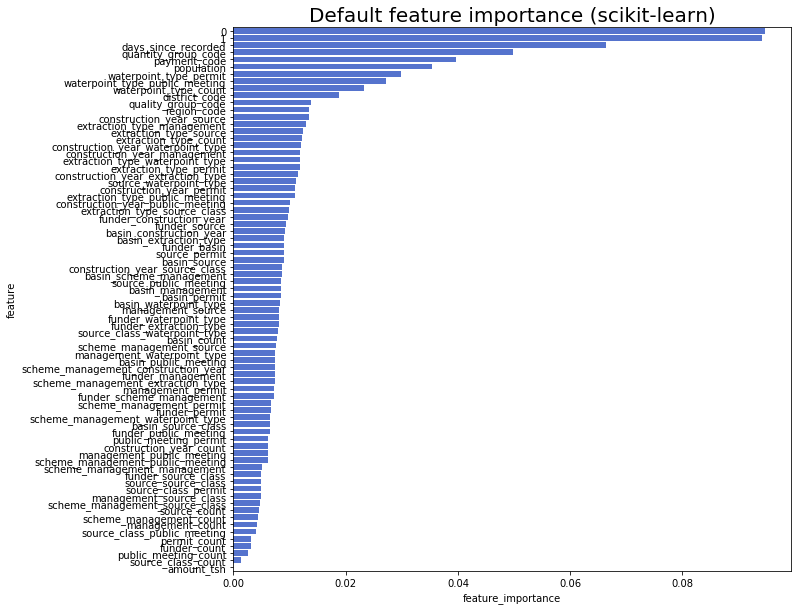

In [232]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

In [244]:
train_df_final_top_imp = train_encoded[top_30_features].join(y)
X_test_final_top_imp = X_test_encoded[top_30_features]

In [245]:
train_df_final.shape

(59400, 74)

## 2.8 Export the final dfs

In [246]:
train_df_final_top_imp.to_csv("train_df_final.csv", index=False)
X_test_final_top_imp.to_csv("X_test_final.csv", index=False)

In [247]:
from google.cloud import bigquery

ModuleNotFoundError: No module named 'google'